Import packages

In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np # numerical array processing
import argparse # parse the argument
import imutils # basic image processing (resizing)
import glob # find all images in image directory
import cv2 # opencv bindings

Image display function

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

cv2.matchTemplate trick

In [3]:
args = {
	"template": "hubble-images/template/galaxy-template1.png",
	"images": "hubble-images/images/"
}

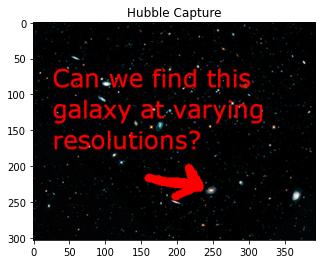

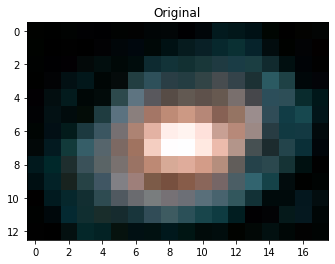

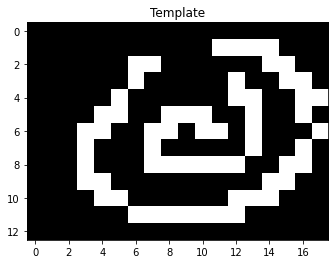

In [13]:
# load the vision from disk
galaxy = cv2.imread("hubble-images/hubble-evolving-universe-00.jpg")
plt_imshow("Hubble Capture", galaxy)

# load the image we're using as the template
template = cv2.imread(args["template"])
plt_imshow("Original", template)

# convert to grayscale
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# change to binary image to avoid minor noise/defects lowering detection score
template = cv2.Canny(template, 50, 200)
# grab the template Height and Weight
(tH, tW) = template.shape[:2]
plt_imshow("Template", template)

Multi-scale Template Matching Results

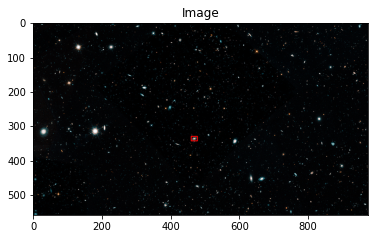

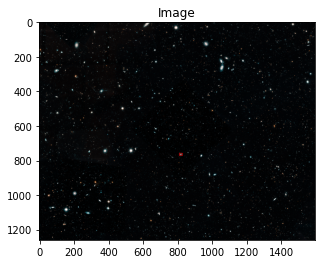

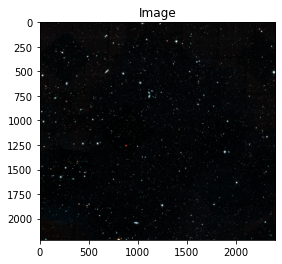

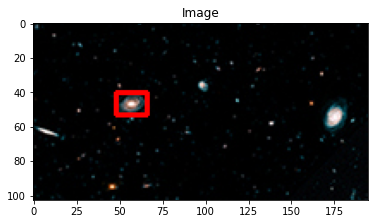

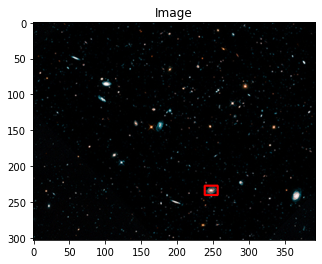

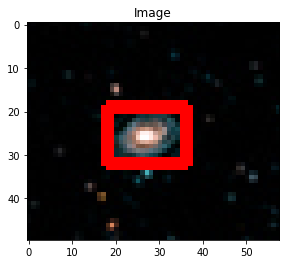

In [5]:
# loop over the images to find the template in
# you may need to change .jpg to .png ...etc.
# glob finds all iamge in the directory
for imagePath in glob.glob(args["images"] + "/*.jpg"):
	# load the image, convert it to grayscale, and initialize the
	# bookkeeping variable to keep track of the matched region
	image = cv2.imread(imagePath)
	# each target image we convert to grayscale
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	found = None

	# loop over the scales of the image
	# construct 20 equally spaced values between 0.2 and 1.0
	# then reverse the array, starting at the largest value
	# value of 1 is original, than 95%...than 91%, 87%...
	for scale in np.linspace(0.2, 1.0, 20)[::-1]:
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing current width times the scale
		resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
		# this is the aspect ratio of the original grayscale image width to resized width
		r = gray.shape[1] / float(resized.shape[1])

		# if the resized image is smaller than the template, then break
		# from the loop
		if resized.shape[0] < tH or resized.shape[1] < tW:
			break

		# detect edges in the resized, grayscale image and apply template
		# matching to find the template in the image
		edged = cv2.Canny(resized, 50, 200)
		result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
		# get the max value found in the result matrix and get XY coordinates
		(_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

		# check to see if the iteration should be visualized
		if args.get("visualize", False):
			# draw a bounding box around the detected region
			# this happens at each layer
			clone = np.dstack([edged, edged, edged])
			cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
				(maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
			cv2.imshow("Visualize", clone)
			cv2.waitKey(0)

		# if we have found a new maximum correlation value, then update
		# the bookkeeping variable
		# max tempalte correlation, where it was found XY coordinate and ratio of the pyramid
		if found is None or maxVal > found[0]:
			# maximum correlation value
			# XY coordinate where it can be found
			# r is the aspect ratio
			found = (maxVal, maxLoc, r)

	# this keeps track of the best match between template and image in what layer and cooridnates
	# unpack the bookkeeping variable and compute the (x, y) coordinates
	# of the bounding box based on the resized ratio
	(_, maxLoc, r) = found
	# for each coordinate, multiply where the template was found times the ratio of that layer
	(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
	(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

	# draw a bounding box around the detected result and display the image
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
	plt_imshow("Image", image)
